# Exploratory Data Analysis of Weather in Illinois

In [1]:
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library

In [2]:
raw_weather_data = pd.read_parquet("./data/raw_weather.parquet", engine = "pyarrow") # load the data based on the desired data types and columns
raw_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084993 entries, 0 to 19084992
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         string 
 1   date       string 
 2   time       string 
 3   element    string 
 4   value      float64
 5   qflag      string 
 6   latitude   float64
 7   longitude  float64
 8   name       string 
 9   elevation  float64
dtypes: float64(4), string(6)
memory usage: 1.4 GB


In [3]:
raw_weather_data["qflag"].unique() # The qflag represents quality of the measurement (we want the rows that don't have quality issues which is denoted <NA>)

<StringArray>
[<NA>, 'I', 'L', 'D', 'S', 'M', 'O', 'G', 'W', 'X', 'K', 'Z', 'N', 'T', 'R']
Length: 15, dtype: string

In [4]:
raw_weather_data["element"].unique() # Unique elements to gather data from. See the following website for more details https://docs.opendata.aws/noaa-ghcn-pds/readme.html#:~:text=SNWD%20%3D%20Snow%20depth%20(mm),temperature%20(tenths%20of%20degrees%20C)

<StringArray>
['PRCP', 'SNOW', 'SNWD', 'TMIN', 'DAPR', 'SX52', 'TMAX', 'TOBS', 'SN32',
 'EVAP', 'SN52', 'WT01', 'WT04', 'SX32', 'WT03', 'WT06', 'WT11', 'WESD',
 'WESF', 'TAVG', 'MDPR', 'WSFG', 'WDMV', 'MNPN', 'WT05', 'MXPN', 'AWND',
 'PGTM', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT08', 'DASF', 'FMTM', 'TSUN',
 'MDEV', 'WT02', 'WDFG', 'WT14', 'WT16', 'WT18', 'SN53', 'DAEV', 'SX53',
 'MDSF', 'WT09', 'WT15', 'WT17', 'WT07', 'DAWM', 'MDWM', 'WT10', 'PSUN',
 'WT13', 'WT22', 'ACMH', 'WDF1', 'WSF1', 'ACSH', 'ASLP', 'ADPT', 'WT21',
 'RHMX', 'WT19', 'RHAV', 'AWBT', 'ASTP', 'RHMN', 'WV18', 'SN02', 'SN03',
 'SX03', 'SX02', 'SX12', 'SN12', 'WV03', 'WV20', 'WV01']
Length: 79, dtype: string

In [5]:
element_count = raw_weather_data.groupby("element")["element"].count().sort_values()
element_count

element
WV01          1
WV18          1
PSUN          2
WT10         13
WV20         19
         ...   
TMIN    1678326
TMAX    1679119
SNWD    2693577
SNOW    3964602
PRCP    5183260
Name: element, Length: 79, dtype: int64

In [7]:
num_of_stations = raw_weather_data["name"].nunique() # number of stations in Illinois
num_of_stations

1950

In [8]:
raw_weather_data.shape

(19084993, 10)

In [9]:
raw_weather_data["time"].fillna("0000", inplace = True) # replace all nan values with "0000"

In [10]:
np.sort(raw_weather_data["time"].apply(len).unique()) # helps to verify how many unique length characters there was in the "time" column. 
# there should only be one of length 4 characters to be able to parse into datetime format.

array([4])

In [11]:
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00") # added a seconds placeholder for parsing
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"]) # converts string format to datetime format for the time column

In [12]:
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"]) # converts the string format to a datetime format for the date column
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"] # combines date and time into the same column which can be accessed via object attributes
raw_weather_data.drop(columns = ["time"], inplace = True) # drops the redundant time column
raw_weather_data = raw_weather_data[raw_weather_data["qflag"].isna()].drop(columns = ["qflag"]) # gets rid of the rows that have quality issues
raw_weather_data

,id,date,element,value,latitude,longitude,name,elevation
0,USC00111458,1997-09-01 07:00:00,PRCP,0.0,41.0092,-87.8242,CHEBANSE 5 E RIVER,181.4
1,USC00111664,1997-12-28 07:00:00,PRCP,0.0,38.5047,-88.4094,CISNE 2 S,138.4
2,USC00115935,1997-10-02 07:00:00,PRCP,0.0,39.9842,-90.7525,MT STERLING,216.1
3,USC00119241,1997-11-13 07:00:00,PRCP,0.0,39.4408,-90.3789,WHITE HALL 1 E,176.8
4,USC00110187,1997-03-15 16:00:00,PRCP,0.0,37.5222,-89.2486,ANNA 4 N,180.7
...,...,...,...,...,...,...,...,...
19084988,USC00119021,1994-10-04 07:00:00,TMIN,78.0,40.7939,-87.7544,WATSEKA 2NW,191.4
19084989,USC00119021,1994-11-29 07:00:00,TOBS,-28.0,40.7939,-87.7544,WATSEKA 2NW,191.4
19084990,USC00119021,1994-03-02 07:00:00,TOBS,-72.0,40.7939,-87.7544,WATSEKA 2NW,191.4
19084991,USC00119021,1994-03-12 07:00:00,TOBS,17.0,40.7939,-87.7544,WATSEKA 2NW,191.4


### The cell below pivots the element values into columns which are more useful in column format.

In [13]:
raw_weather_pivot = raw_weather_data.pivot(columns = "element", values = "value")
raw_weather_pivot

element,ACMH,ACSH,ADPT,ASLP,ASTP,AWBT,AWND,DAEV,DAPR,DASF,...,WT16,WT17,WT18,WT19,WT21,WT22,WV01,WV03,WV18,WV20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19084988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19084989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19084990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19084991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
transformed_data = pd.concat([raw_weather_data, raw_weather_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_data.drop_duplicates(inplace = True)
transformed_data.drop(columns = ["element", "value"], inplace = True) # drop the element and value columns
transformed_data = transformed_data[transformed_data["date"].dt.year != 2024] # drops the rows that contain the year 2024 (an artifact of concatenating the dataframes from earlier)
transformed_data

In [15]:
temp_data = transformed_data[["id", "name", "date", "TMIN", "TMAX", "TOBS", "TAVG"]]
convert_temp = lambda df, temp_label: 9/5 * (df[temp_label] / 10) + 32 # convert tenths of a degree Celsius to Fahrenheit
temp_data.loc[:, "TMIN"] = convert_temp(temp_data, "TMIN")
temp_data.loc[:, "TMAX"] = convert_temp(temp_data, "TMAX")
temp_data.loc[:, "TOBS"] = convert_temp(temp_data, "TOBS")
temp_data.loc[:, "TAVG"] = convert_temp(temp_data, "TAVG")

### This cell below plots the minimum, maximum, and observed temperatures.

#### Note: ``pandas.DataFrame.plot`` attribute can be used to shorten the time to make a plot. The tradeoff is less customization of the plot.

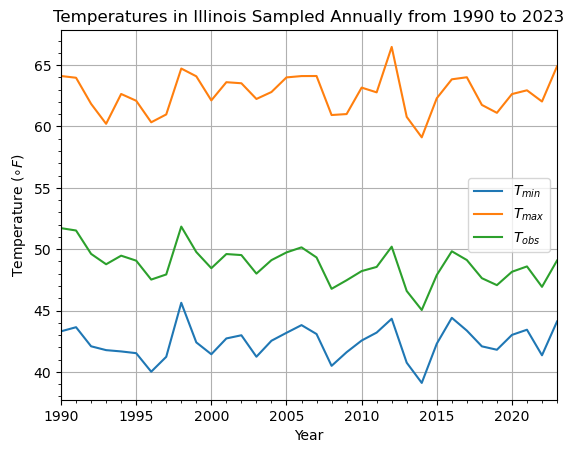

In [21]:
# Resample the temperature data annually and calculate the mean
numeric_data = temp_data.select_dtypes(include = ["datetime64[ns]", "float"])
resampled_data = numeric_data.resample("Y", on="date").mean()
resampled_data.index = pd.to_datetime(resampled_data.index)
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plotting TMIN, TMAX, and TOBS
plt.plot(resampled_data.index.year, resampled_data["TMIN"], label= tmin_label)
plt.plot(resampled_data.index.year, resampled_data["TMAX"], label= tmax_label)
plt.plot(resampled_data.index.year, resampled_data["TOBS"], label= tobs_label)

# Set labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Display the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max())

# Display the grid
plt.grid()

# Display minor ticks
plt.minorticks_on()

# Show the plot
plt.show()

### The cell below plots the temeprature difference for the minimum, maximum, and observed temperatures.

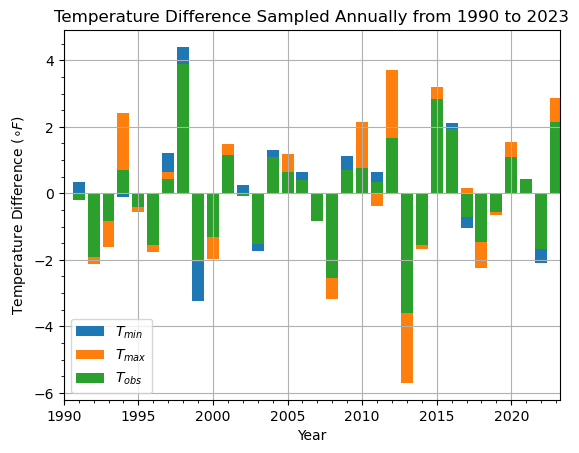

In [17]:
# Plotting the temperature gradient (difference) for TMIN, TMAX, TOBS
plt.bar(resampled_data.index.year, resampled_data["TMIN"].diff(), label = tmin_label)
plt.bar(resampled_data.index.year, resampled_data["TMAX"].diff(), label = tmax_label)
plt.bar(resampled_data.index.year, resampled_data["TOBS"].diff(), label = tobs_label)

# Adding labels and legend
plt.xlabel("Year")
plt.ylabel(r"Temperature Difference ($\circ F$)")
plt.legend(loc = "lower left")

# Fix the x-range so that all the bars for each year display properly
plt.xlim(resampled_data.index.year.min(), resampled_data.index.year.max() + 0.25)

# Adding a title
plt.title("Temperature Difference Sampled Annually from 1990 to 2023")

# Display grid and minor ticks
plt.grid()
plt.minorticks_on()

# Show the plot
plt.show()

### The cells below gives us statistics on the number of observations per station.

In [18]:
num_obs_per_station = transformed_data.groupby("name", as_index = False)["date"].count() # number of observations per station w.r.t. TMIN, TMAX, TOBS
num_obs_per_station.rename(columns = {"date": "obs_count"}, inplace = True)
num_obs_per_station.sort_values(by = "obs_count")

,name,obs_count
402,CLARENDON HILLS 0.6 S,1
164,BLOOMINGTON 4.3 ENE,16
1602,RUSHVILLE 2.4 S,25
100,BARTLETT 1.4 SE,26
859,INA,35
...,...,...
1177,MOLINE QUAD CITY INTL AP,191712
381,CHICAGO OHARE INTL AP,197023
688,GENERAL WAYNE A DOWNING INTL A,198435
1698,SPRINGFIELD ABRAHAM LINCOLN CA,199085


In [19]:
num_obs_per_station.describe()

,obs_count
count,1950.000000
mean,9756.546154
std,20433.130749
min,1.000000
25%,698.750000
50%,2143.500000
75%,7348.250000
max,202536.000000


In [20]:
stations_in_between_quantiles = (num_obs_per_station["obs_count"] > num_obs_per_station["obs_count"].quantile(0.25)) & (num_obs_per_station["obs_count"] < num_obs_per_station["obs_count"].quantile(0.75))
num_obs_per_station[stations_in_between_quantiles].sort_values(by = "obs_count")

,name,obs_count
1176,MOLINE BRG,701
106,BATAVIA 0.8 S,703
1470,PIPER CITY 0.2 ESE,707
420,COLLISON 2.0 SE,708
1081,MAPLE PARK 0.1 S,712
...,...,...
1265,NAPERVILLE 2.4 SE,7271
512,DEWEY 1.6 NNW,7281
635,FINDLAY 2NW,7290
620,EVANSTON 1.4 N,7341
